## Imports



In [ ]:
%run Library_Imports.ipynb

### Table of Contents

* [Data](#chapter1)
    * [Loading](#section_1_1)
    * [Pre-Processing](section_1_2)
* [Decision Trees](#chapter2)
    * [Initial Decision Tree Model - without protected attributes](#section_2_1)
    * [Initial Decision Tree Model - with protected attributes](#section_2_2)
    * [Feature Importance](#section_2_3)
    * [Hypertune Decision Tree Model](#section_2_4)
    * [HyperTune With Protected Attributes](#section_2_5)
    * [Feature Importance](#section_2_6)

* [Balancing Dataset](#chapter3)
    * [Data Pre-Processing & Analysis](#section_3_1)
    * [Decision Tree - without  hypertuning](#section_3_2)
    * [HyperTune Decision Tree](#section_3_3)
    * [Decision Tree - with hyperparamters](#section_3_4)
* [Analysis of Fairness](#chapter4)
    * [Similar outcomes for similar individuals](#section_4_1)
    * [Distribution](#section_4_2)
    * [Analysis of Similarity on Incorrect predictions](#section_4_3)


## Data <a class="anchor" id="chapter1"></a>

### Load Data <a class="anchor" id="section_1_1"></a>

This Data was provided pre-precessed but can be found at: 

https://www.kaggle.com/datasets/uciml/adult-census-income

In [ ]:
train_data = pd.read_csv('adult.data', sep=",", header=None, skipinitialspace=True)


In [ ]:
test_data = pd.read_csv('adult.test', sep=",", skiprows=1, header=None, skipinitialspace=True)


In [ ]:
print(len(train_data))
print(len(test_data))

# because test data is half of that of training - split it into two randomly shuffled sets of test and eval 

32561
16281


Add column headings

In [ ]:
column_headers = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
                  'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 
                  'native-country', 'earnings']

In [ ]:
# apply headers to the data
train_data.columns = column_headers
test_data.columns = column_headers

### Data Pre-processing <a class="anchor" id="section_1_2"></a>

Split data into a features and targets dataframe. 

**Method:**

1. Train dataset is used to train and test models
2. Test dataset is used to evaluate on unseen data
3. The features are excluding all protected attributes.
4. Target is income column
5. Categorical columns are encoded 
6. Both Train and Test Data are scaled to a normal range 



In [ ]:
features = train_data.drop(['earnings', 'marital-status', 'relationship', 'race', 'sex', 'native-country'], True)
targets = train_data['earnings']

In [ ]:
# Split the data with 20% held out for testing 

X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size = 0.2, random_state = 30)

##### Encode the categorical columns (Workclass, Education and Occupation) with LabelEncoder and scale the values to a normal range

In [ ]:
le = LabelEncoder()

X_train.workclass= le.fit_transform(X_train.workclass.values)
X_train.education= le.fit_transform(X_train.education.values)
X_train.occupation= le.fit_transform(X_train.occupation.values)

X_test.workclass= le.fit_transform(X_test.workclass.values)
X_test.education= le.fit_transform(X_test.education.values)
X_test.occupation= le.fit_transform(X_test.occupation.values)


In [ ]:
# Normalise the dataset 

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

# Decision Trees<a class="anchor" id="chapter2"></a>

While Decision Trees can be said to be less complex in comparison to that of a Neural Network or SVM approach, when considering the fairness, interpretability and ‘black box’ nature of the possible algorithms, the prediction outcomes from Decision Trees are easier to back trace and understand their reasoning. This was deemed more important to create explainable and fair models rather than prioritising neural complexity.

## Initial Decision Tree Model - excluding protected attributes <a class="anchor" id="section_2_1"></a>

In [ ]:
# create instance of DT 
decision_tree = DecisionTreeClassifier()


In [ ]:
# fit the model
decision_tree.fit(X_train, Y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# predict with the model on the test set

Y_pred = decision_tree.predict(X_test)

### Test Set Metrics

In [ ]:
print("Accuracy on Test Set: %s%%" % (100*accuracy_score(Y_test, Y_pred)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Accuracy on Test Set: 78.08997389835713%
[[4233  737]
 [ 690  853]]
              precision    recall  f1-score   support

       <=50K       0.86      0.85      0.86      4970
        >50K       0.54      0.55      0.54      1543

    accuracy                           0.78      6513
   macro avg       0.70      0.70      0.70      6513
weighted avg       0.78      0.78      0.78      6513



### Predict on unseen Test Data

In [ ]:
# Drop NaN's and clean punctuation from dataset

test_data.dropna()
test_data.earnings.replace({"<=50K.": "<=50K", ">50K.": ">50K"}, inplace=True)

In [ ]:
# Create target and feature datasets with the protected attributes removed from the features

test_features = test_data.drop(['earnings', 'marital-status', 'relationship', 'race', 'sex', 'native-country'], True)
test_Targets = test_data['earnings']

In [ ]:
# Encode categorical columns

test_features.workclass= le.fit_transform(test_features.workclass.values)
test_features.education= le.fit_transform(test_features.education.values)
test_features.occupation= le.fit_transform(test_features.occupation.values)

In [ ]:
# Scale the data to the normal range 

test_data_altered = pd.DataFrame(scaler.fit_transform(test_features), columns = test_features.columns)

In [ ]:
# Predict with unseen data

test_pred = decision_tree.predict(test_data_altered)

### Metrics

In [ ]:
print("Accuracy on Unseen Test Set: %s%%" % (100*accuracy_score(test_Targets, test_pred)))
print(confusion_matrix(test_Targets, test_pred))
print(classification_report(test_Targets, test_pred))

Accuracy on Unseen Test Set: 76.38351452613476%
[[10481  1954]
 [ 1891  1955]]
              precision    recall  f1-score   support

       <=50K       0.85      0.84      0.85     12435
        >50K       0.50      0.51      0.50      3846

    accuracy                           0.76     16281
   macro avg       0.67      0.68      0.67     16281
weighted avg       0.77      0.76      0.76     16281



**Outcome:** The models both have a decent accuracy but in diving into the confusion matrix it is clear that the skew in the data towards <=50K is effecting the performance in the class of >50K.

## Initial Decision Tree Model - with protected attributes  <a class="anchor" id="section_2_2"></a>

**Protected attributes are included to test the method of excluding these for fairness**

In [ ]:
# Drop only the feature column
all_features = train_data.drop(['earnings'], True)


In [ ]:
# Split the data with 20% in a test set
X_all_train, X_all_test, Y_all_train, Y_all_test = train_test_split(all_features, targets, 
                                                                    test_size = 0.2, random_state = 30)


##### Encode the categorical columns (Workclass, Education and Occupation) with LabelEncoder and scale the values to a normal range

In [ ]:
le = LabelEncoder()

X_all_train.workclass= le.fit_transform(X_all_train.workclass.values)
X_all_train.education= le.fit_transform(X_all_train.education.values)
X_all_train.occupation= le.fit_transform(X_all_train.occupation.values)
X_all_train['marital-status'] = le.fit_transform(X_all_train['marital-status'].values)
X_all_train.relationship= le.fit_transform(X_all_train.relationship.values)
X_all_train.race= le.fit_transform(X_all_train.race.values)
X_all_train.sex= le.fit_transform(X_all_train.sex.values)
X_all_train['native-country']= le.fit_transform(X_all_train['native-country'].values)


X_all_test.workclass= le.fit_transform(X_all_test.workclass.values)
X_all_test.education= le.fit_transform(X_all_test.education.values)
X_all_test.occupation= le.fit_transform(X_all_test.occupation.values)
X_all_test['marital-status'] = le.fit_transform(X_all_test['marital-status'].values)
X_all_test.relationship= le.fit_transform(X_all_test.relationship.values)
X_all_test.race= le.fit_transform(X_all_test.race.values)
X_all_test.sex= le.fit_transform(X_all_test.sex.values)
X_all_test['native-country']= le.fit_transform(X_all_test['native-country'].values)

In [ ]:
# Normalise the dataset 

scaler = StandardScaler()

X_all_train = pd.DataFrame(scaler.fit_transform(X_all_train), columns = X_all_train.columns)

X_all_test = pd.DataFrame(scaler.transform(X_all_test), columns = X_all_test.columns)

In [ ]:
# create instance of DT 

decision_tree_all = DecisionTreeClassifier()


In [ ]:
# Fit the model

decision_tree_all.fit(X_all_train, Y_all_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Test Set Metrics

In [ ]:
# predict with the model on the test set

Y_all_pred = decision_tree_all.predict(X_all_test)

In [ ]:
print("Accuracy on Test Set: %s%%" % (100*accuracy_score(Y_all_test, Y_all_pred)))
print(confusion_matrix(Y_all_test, Y_all_pred))
print(classification_report(Y_all_test, Y_all_pred))

Accuracy on Test Set: 81.68278826961462%
[[4326  644]
 [ 549  994]]
              precision    recall  f1-score   support

       <=50K       0.89      0.87      0.88      4970
        >50K       0.61      0.64      0.62      1543

    accuracy                           0.82      6513
   macro avg       0.75      0.76      0.75      6513
weighted avg       0.82      0.82      0.82      6513



### Test on Unseen Data

In [ ]:
# Drop NaN's and clean punctuation from dataset

test_data.dropna()
test_data.earnings.replace({"<=50K.": "<=50K", ">50K.": ">50K"}, inplace=True)

In [ ]:
# Create target and feature datasets with the protected attributes included in the features

unseen_test_features = test_data.drop(['earnings'], True)
unseen_test_targets = test_data['earnings']

In [ ]:
# Encode categorical columns

le = LabelEncoder()

unseen_test_features.workclass= le.fit_transform(unseen_test_features.workclass.values)
unseen_test_features.education= le.fit_transform(unseen_test_features.education.values)
unseen_test_features.occupation= le.fit_transform(unseen_test_features.occupation.values)
unseen_test_features['marital-status'] = le.fit_transform(unseen_test_features['marital-status'].values)
unseen_test_features.relationship= le.fit_transform(unseen_test_features.relationship.values)
unseen_test_features.race= le.fit_transform(unseen_test_features.race.values)
unseen_test_features.sex= le.fit_transform(unseen_test_features.sex.values)
unseen_test_features['native-country']= le.fit_transform(unseen_test_features['native-country'].values)


In [ ]:
# Normalise the dataset 

scaler = StandardScaler()

unseen_test_features = pd.DataFrame(scaler.fit_transform(unseen_test_features), columns = unseen_test_features.columns)

In [ ]:
# Predict with the unseen data

unseen_test_pred = decision_tree_all.predict(unseen_test_features)

In [ ]:
print("Accuracy on Test Set: %s%%" % (100*accuracy_score(unseen_test_targets, unseen_test_pred)))
print(confusion_matrix(unseen_test_targets, unseen_test_pred))
print(classification_report(unseen_test_targets, unseen_test_pred))

Accuracy on Test Set: 79.95823352373932%
[[10731  1704]
 [ 1559  2287]]
              precision    recall  f1-score   support

       <=50K       0.87      0.86      0.87     12435
        >50K       0.57      0.59      0.58      3846

    accuracy                           0.80     16281
   macro avg       0.72      0.73      0.73     16281
weighted avg       0.80      0.80      0.80     16281



**Outcome:** Similar to before the models both have a good accuracy but in looking at the confusion matrix it is clear that the protected attributes have improved perfomance especially for the >50K category which had less samples.

## Compare Importance of Features <a class="anchor" id="section_2_3"></a>

In this section we are looking to understand which features carried the most weight in the predictions from our Decision Trees.

In [ ]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(decision_tree.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
fnlwgt,0.292
age,0.191
capital-gain,0.160
education-num,0.105
hours-per-week,0.080
occupation,0.061
capital-loss,0.053
workclass,0.042
education,0.016


In [ ]:
importances_all = pd.DataFrame({'feature':X_all_train.columns,'importance':np.round(decision_tree_all.feature_importances_,3)})
importances_all = importances_all.sort_values('importance',ascending=False).set_index('feature')
importances_all.head(15)

,importance
feature,
fnlwgt,0.206
relationship,0.193
education-num,0.120
age,0.117
capital-gain,0.115
hours-per-week,0.072
occupation,0.060
workclass,0.035
capital-loss,0.035


**Outcome:** Clear from the comparison of features impacting the decision tree that from the stated protected attributes the one that affects decisions the most is relationship. However, the safest and fairest option is to remove all of these protected features. 

The importance will again be analysed following hypertuning. 

## Hypertune Decision Tree Model  <a class="anchor" id="section_2_4"></a>

**Method:**

1. Create Grid Search of Parameters:
    a. Criterion - the measuring of the quality of the split
    b. Maximum Depth - the depth of the tree
    
2. Do an initial grid search to find the best Hparams
3. Train the Decision Tree with the Hparams identified

**This is performed with and without protected features in the training dataset**

### Without Protected Attributes

In [ ]:
# Create Decision Tree

decision_tree_ht = DecisionTreeClassifier()

In [ ]:
# Create the Hypertuning pipeline

pipe = Pipeline(steps=[('dec_tree', decision_tree_ht)])

In [ ]:
# Set-up parameters to search

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]


In [ ]:
# Add Parameters to dictionary 
parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth)

In [ ]:
# Create the grid search with the pipeline and parameters
clf_GS = GridSearchCV(pipe, parameters)

# Fitting the grid search
clf_GS.fit(X_train, Y_train)

# Viewing The Best Parameters
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])

   

Best Criterion: gini
Best max_depth: 8

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


### Train DT with Hyperparams





In [ ]:
decision_tree_ht_args = DecisionTreeClassifier(criterion='gini', max_depth=8)
decision_tree_ht_args.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# Predict with test data 

Y_pred_ht = decision_tree_ht_args.predict(X_test)

In [ ]:
print("Accuracy on Test Set: %s%%" % (100*accuracy_score(Y_test, Y_pred_ht)))
print(confusion_matrix(Y_test, Y_pred_ht))
print(classification_report(Y_test, Y_pred_ht))

Accuracy on Test Set: 83.60202671579917%
[[4682  288]
 [ 780  763]]
              precision    recall  f1-score   support

       <=50K       0.86      0.94      0.90      4970
        >50K       0.73      0.49      0.59      1543

    accuracy                           0.84      6513
   macro avg       0.79      0.72      0.74      6513
weighted avg       0.83      0.84      0.82      6513



**Outcome:** See an improvement in both the accuracy and the F1 score for both classes. However >50K is still low in F1. 

## HyperTune With Protected Attributes <a class="anchor" id="section_2_5"></a>

In [ ]:
# Create Decision Tree

decision_tree_ht_all = DecisionTreeClassifier()

In [ ]:
# Create Pipeline for same Hparams as above

pipe_all = Pipeline(steps=[('dec_tree', decision_tree_ht_all)])

In [ ]:
# Create grid search with the pipeline and Hparams
clf_GS_all = GridSearchCV(pipe_all, parameters)

# Fitting the grid search
clf_GS_all.fit(X_all_train, Y_all_train)

# Viewing The Best Parameters
print('Best Criterion:', clf_GS_all.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS_all.best_estimator_.get_params()['dec_tree__max_depth'])
print(); print(clf_GS_all.best_estimator_.get_params()['dec_tree'])


Best Criterion: gini
Best max_depth: 10

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


### Train DT with Hyperparams





In [ ]:
decision_tree_ht_all_args = DecisionTreeClassifier(criterion='gini', max_depth=8)
decision_tree_ht_all_args.fit(X_all_train, Y_all_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
# Predict with the test set
Y_pred_ht_all = decision_tree_ht_all_args.predict(X_all_test)

In [ ]:
print("Accuracy on Test Set: %s%%" % (100*accuracy_score(Y_all_test, Y_pred_ht_all)))
print(confusion_matrix(Y_all_test, Y_pred_ht_all))
print(classification_report(Y_all_test, Y_pred_ht_all))

Accuracy on Test Set: 85.92046675879011%
[[4730  240]
 [ 677  866]]
              precision    recall  f1-score   support

       <=50K       0.87      0.95      0.91      4970
        >50K       0.78      0.56      0.65      1543

    accuracy                           0.86      6513
   macro avg       0.83      0.76      0.78      6513
weighted avg       0.85      0.86      0.85      6513



**Outcome:** As expected we ee an improvement in both the accuracy and the F1 score for both classes again, by using the protected attributes

## Compare Importance of Features <a class="anchor" id="section_2_6"></a>

In [ ]:
importances_ht = pd.DataFrame({'feature':X_train.columns,'importance':np.round(decision_tree_ht_args.feature_importances_,3)})
importances_ht = importances_ht.sort_values('importance',ascending=False).set_index('feature')
importances_ht.head(15)

,importance
feature,
capital-gain,0.381
education-num,0.223
age,0.174
capital-loss,0.118
hours-per-week,0.068
occupation,0.023
fnlwgt,0.006
workclass,0.005
education,0.001


In [ ]:
importances_ht_all = pd.DataFrame({'feature':X_all_train.columns,'importance':np.round(decision_tree_ht_all_args.feature_importances_,3)})
importances_ht_all = importances_ht_all.sort_values('importance',ascending=False).set_index('feature')
importances_ht_all.head(15)

,importance
feature,
relationship,0.391
education-num,0.219
capital-gain,0.217
capital-loss,0.060
age,0.046
hours-per-week,0.039
occupation,0.012
fnlwgt,0.009
workclass,0.002


**Outcome:** 

Clear that over fine tuning that capital gain takes the lead as the most important feature. This can be seen in the graph plots as a high number of those in the <=50K having 0 capital gain. Compared to those of >50K that have a lower proportion around zero. 

In all the model tests it is also clear that the <=50K category has a higher precision and recall due to the imbalance of the category having significantly more data points than that >50K. 

**The next test will aim to equalise this playing field.**

## Balancing Dataset <a class="anchor" id="chapter3"></a>

With the observed skew in the dataset towards those with <=50K being the majority cateory, we are going to see how removing the imbalance effects predictions.

The approach was to randomly sample from the majority class to even the categories. This was seen as the simplest approach but affects the size of the dataset. Another option would have been to upsample the minority category.


### Data Pre-Processing & Analysis <a class="anchor" id="section_3_1"></a>

In [ ]:
train_data = pd.read_csv('adult.data', sep=",", header=None, skipinitialspace=True)
test_data = pd.read_csv('adult.test', sep=",", skiprows=1, header=None, skipinitialspace=True)

column_headers = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 
'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'earnings']


train_data.columns = column_headers
test_data.columns = column_headers

test_data.earnings.replace({"<=50K.": "<=50K", ">50K.": ">50K"}, inplace=True)


In [ ]:
# analyse data split of >50K and <=50K
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,earnings
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
print("Train Data count:", train_data.groupby('earnings').count())
print("Test Data count:", test_data.groupby('earnings').count())

Train Data count:             age  workclass  ...  hours-per-week  native-country
earnings                    ...                                
<=50K     24720      24720  ...           24720           24720
>50K       7841       7841  ...            7841            7841

[2 rows x 14 columns]
Test Data count:             age  workclass  ...  hours-per-week  native-country
earnings                    ...                                
<=50K     12435      12435  ...           12435           12435
>50K       3846       3846  ...            3846            3846

[2 rows x 14 columns]


In [ ]:
def even_and_shuffle_data(df):
    
    """ Function to sample the dataset and even out over the two categories
    
    Inputs:
    
        df (Pandas DataFrame):
            Full original dataframe
    
    Returns:
        
        even_df (Pandas DataFrame):
            Sampled dataframe of even classses
    
    """
    df_greater = df.loc[df['earnings'] == '<=50K']
    df_lessthan = df.loc[df['earnings'] == '>50K']

    greater_sample = df_greater.sample(len(df_lessthan))

    even_df = greater_sample.append(df_lessthan, ignore_index=True)
    
    # shuffle the data back into random order
    even_df = shuffle(even_df)
    even_df = even_df.reset_index(drop=True)

    return even_df

###### Perform skew correction on both the train and test data 


In [ ]:
new_train = even_and_shuffle_data(train_data)
new_test =  even_and_shuffle_data(test_data)

##### Remove the protected attributes and split the training data 

In [ ]:
even_features = new_train.drop(['earnings','marital-status', 'relationship', 'race', 'sex', 'native-country'], True)
even_targets = new_train['earnings']

In [ ]:
# Split the data with 20% held out for testing 

X_train, X_test, Y_train, Y_test = train_test_split(even_features, even_targets, test_size = 0.2, random_state = 30)

##### Encode the categorical columns with LabelEncoder and scale the values to a normal range


In [ ]:
le = LabelEncoder()

X_train.workclass= le.fit_transform(X_train.workclass.values)
X_train.education= le.fit_transform(X_train.education.values)
X_train.occupation= le.fit_transform(X_train.occupation.values)

X_test.workclass= le.fit_transform(X_test.workclass.values)
X_test.education= le.fit_transform(X_test.education.values)
X_test.occupation= le.fit_transform(X_test.occupation.values)


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
# Normalise the dataset 

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

### Decision Tree - without  hypertuning <a class="anchor" id="section_3_2"></a>

In [ ]:
# Create the Decision Tree, fit and predict on the test set

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train, Y_train)

Y_pred = decision_tree.predict(X_test)

In [ ]:
print("Accuracy on Test Set: %s%%" % (100*accuracy_score(Y_test, Y_pred)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Accuracy on Test Set: 70.38571883965572%
[[1091  489]
 [ 440 1117]]
              precision    recall  f1-score   support

       <=50K       0.71      0.69      0.70      1580
        >50K       0.70      0.72      0.71      1557

    accuracy                           0.70      3137
   macro avg       0.70      0.70      0.70      3137
weighted avg       0.70      0.70      0.70      3137



**Outcome:** Clear reduction in the accuracy compared to above however, the model is more even over the two categories.

### HyperTune Decision Tree <a class="anchor" id="section_3_3"></a>

This is the same method as above using Grid Search and fitting the model on the best Hparams from the Grid Search.

In [ ]:
# Create decision tree, create pipeline for tuning and specify Hparameters to search

decision_tree_tuned = DecisionTreeClassifier()

pipe = Pipeline(steps=[('dec_tree', decision_tree_tuned)])

# parameters to search - leaf nodes was added to analyse affect 

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
max_leaf_nodes = [2,4,6,8,10,12]

parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth,
                  dec_tree__max_leaf_nodes=max_leaf_nodes)

In [ ]:
# Create Grid Search 
clf_GS = GridSearchCV(pipe, parameters)

# Fitting the grid search
clf_GS.fit(X_train, Y_train)

# Viewing The Best Parameters
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best max_leaf_nodes:', clf_GS.best_estimator_.get_params()['dec_tree__max_leaf_nodes'])

print(clf_GS.best_estimator_.get_params()['dec_tree'])

  

Best Criterion: gini
Best max_depth: 8
Best max_leaf_nodes: 12
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=12,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


### Decision Tree - with hyperparamters <a class="anchor" id="section_3_4"></a>

In [ ]:
# Create Decision Tree
decision_tree_params = DecisionTreeClassifier(max_depth = 8, max_leaf_nodes = 12)


In [ ]:
# Fit the model 
decision_tree_params.fit(X_train, Y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=12,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Test Set Metrics

In [ ]:
# Predict with the test data 

Y_pred = decision_tree_params.predict(X_test)

In [ ]:
print("Accuracy on Test Set: %s%%" % (100*accuracy_score(Y_test, Y_pred)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Accuracy on Test Set: 75.70927637870577%
[[1044  536]
 [ 226 1331]]
              precision    recall  f1-score   support

       <=50K       0.82      0.66      0.73      1580
        >50K       0.71      0.85      0.78      1557

    accuracy                           0.76      3137
   macro avg       0.77      0.76      0.76      3137
weighted avg       0.77      0.76      0.75      3137



**Outcome:** Clear improvement in the both the accuracy and F1-Scores compared to above and the better split over the two categories is maintained.

### Importance of Features

**Outcome:** Can see that only 5 features in this model had an impact.

In [ ]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(decision_tree_params.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
age,0.435
education-num,0.293
capital-gain,0.191
hours-per-week,0.054
capital-loss,0.027
workclass,0.000
fnlwgt,0.000
education,0.000
occupation,0.000


### Test Tuned Decision Tree on Unseen Data

In [ ]:
# Prepare the unseen data 

new_test_targets = new_test['earnings']
new_test_us = new_test.copy()
new_test_us = new_test_us.drop(['earnings','marital-status', 'relationship', 'race', 'sex', 'native-country'], True)


##### Encode the categorical columns with LabelEncoder and scale the values to a normal range

In [ ]:
le = LabelEncoder()

new_test_us.workclass= le.fit_transform(new_test_us.workclass.values)
new_test_us.education= le.fit_transform(new_test_us.education.values)
new_test_us.occupation= le.fit_transform(new_test_us.occupation.values)

# Normalise the dataset 

scaler = StandardScaler()

new_test_us = pd.DataFrame(scaler.fit_transform(new_test_us), columns = new_test_us.columns)

In [ ]:
# Predict on the unseen data
new_Y_pred = decision_tree_params.predict(new_test_us)

In [ ]:
print("Accuracy on Test Set: %s%%" % (100*accuracy_score(new_test_targets, new_Y_pred)))
print(confusion_matrix(new_test_targets, new_Y_pred))
print(classification_report(new_test_targets, new_Y_pred))

pred_unseen_test = new_test_us.copy()
pred_unseen_test['Y_True'] = new_test_targets
pred_unseen_test["Y_Pred"] = new_Y_pred

Accuracy on Test Set: 74.14196567862714%
[[2469 1377]
 [ 612 3234]]
              precision    recall  f1-score   support

       <=50K       0.80      0.64      0.71      3846
        >50K       0.70      0.84      0.76      3846

    accuracy                           0.74      7692
   macro avg       0.75      0.74      0.74      7692
weighted avg       0.75      0.74      0.74      7692



**Outcome:** Clear decrease in the performance on the unseen data, however the accuracy and F1-Scores did not vary too much meaning the Decision Tree is capable of handling unseen data and has not been overfitted to the training data.

# Analysis of Fairness  <a class="anchor" id="chapter_4"></a>

To analyse whether the model is fair we create a dataframe with model test data and prediction of class to test the fairness of the model  

In [ ]:
full_testing = new_test_us.copy()
full_testing["Y_Pred"] = new_Y_pred
full_testing["Y_True"] = new_test_targets


## Similar outcomes for similar individuals <a class="anchor" id="section_4_1"></a>

This check is to ensure that similar people within the data are given the same predictive outcome.

In [ ]:
# Create subset dataframes for over and under 50K 

over_50 = full_testing.copy()
over_50.drop(over_50.loc[over_50['Y_True']=="<=50K"].index, inplace=True)

under_50 = full_testing.copy()
under_50.drop(under_50.loc[under_50['Y_True']==">50K"].index, inplace=True)

In [ ]:
# Create blank dataframe to hold results 

corr_over_50 = pd.DataFrame(columns=["pair1", "pair2", "outcome1", "outcome2", "similarity", "match"])


In [ ]:
# check similarity between rows, add to list and check if outcomes matched (0 if not 1 if did)
pair1 = []
pair2 = []
outcome1 = []
outcome2 = []

over_50_lst = over_50[["age", "workclass", "fnlwgt", "education", "education-num", "occupation", "capital-gain", "capital-loss", 
                       "hours-per-week"]].to_numpy().tolist()
Y_pred_col = over_50["Y_Pred"].values

for index, element in enumerate(over_50_lst):
    if index % 2 == 0:
        pair1.append(element)
        outcome1.append(Y_pred_col[index])
    else:
        pair2.append(element)
        outcome2.append(Y_pred_col[index])


if(len(pair1) != len(pair2)):
    pair2.append(over_50_lst[0])
    outcome2.append(Y_pred_col[0])

In [ ]:
# Populate DataFrame with Results

corr_over_50.pair1 = pair1
corr_over_50.pair2 = pair2
corr_over_50.outcome1 = outcome1
corr_over_50.outcome2 = outcome2

In [ ]:
# Measure the Cosine Similarity of the pairs

corr_over_50['similarity'] = corr_over_50.apply(lambda row: 1 - cosine(row['pair1'], row['pair2']), axis=1)


In [ ]:
for i, row in corr_over_50.iterrows():
    if row.outcome1 == row.outcome2:
        corr_over_50.loc[i,'match'] = 1

    else:
        corr_over_50.loc[i,'match'] = 0

In [ ]:
corr_over_50.match = corr_over_50.match.astype(int)

corr_over_50.corr() 

,similarity,match
similarity,1.00000,0.11335
match,0.11335,1.00000


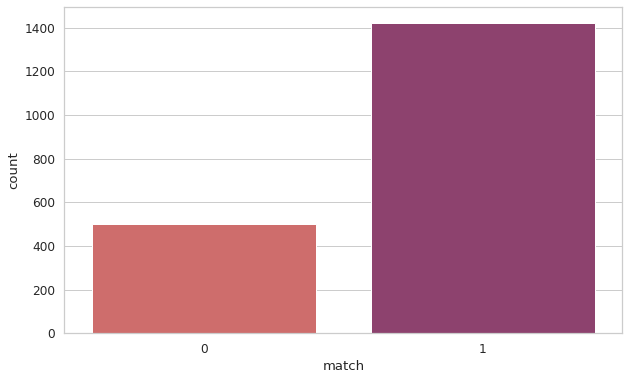

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax = sns.countplot(x="match", data=corr_over_50, palette = "flare")

### Under 50K Measure

In [ ]:
# Create blank dataframe to hold results

corr_under_50 = pd.DataFrame(columns=["pair1", "pair2", "outcome1", "outcome2", "similarity", "match"])


In [ ]:
# check similarity between rows, add to list and check if outcomes matched (0 if not 1 if did)

pair1 = []
pair2 = []
outcome1 = []
outcome2 = []

under_50_lst = under_50[["age", "workclass", "fnlwgt", "education", "education-num", "occupation", "capital-gain", "capital-loss", 
                       "hours-per-week"]].to_numpy().tolist()
Y_pred_col = under_50["Y_Pred"].values

for index, element in enumerate(under_50_lst):
    if index % 2 == 0:
        pair1.append(element)
        outcome1.append(Y_pred_col[index])
    else:
        pair2.append(element)
        outcome2.append(Y_pred_col[index])


if(len(pair1) != len(pair2)):
    pair2.append(under_50_lst[0])
    outcome2.append(Y_pred_col[0])

In [ ]:
# Populate DataFrame with Results

corr_under_50.pair1 = pair1
corr_under_50.pair2 = pair2
corr_under_50.outcome1 = outcome1
corr_under_50.outcome2 = outcome2

In [ ]:
# Measure the Cosine Similarity of the pairs

corr_under_50['similarity'] = corr_under_50.apply(lambda row: 1 - cosine(row['pair1'], row['pair2']), axis=1)

for i, row in corr_under_50.iterrows():
    if row.outcome1 == row.outcome2:
        corr_under_50.loc[i,'match'] = 1

    else:
        corr_under_50.loc[i,'match'] = 0

In [ ]:
corr_under_50.match = corr_under_50.match.astype(int)

corr_under_50.corr() 

,similarity,match
similarity,1.000000,0.203618
match,0.203618,1.000000


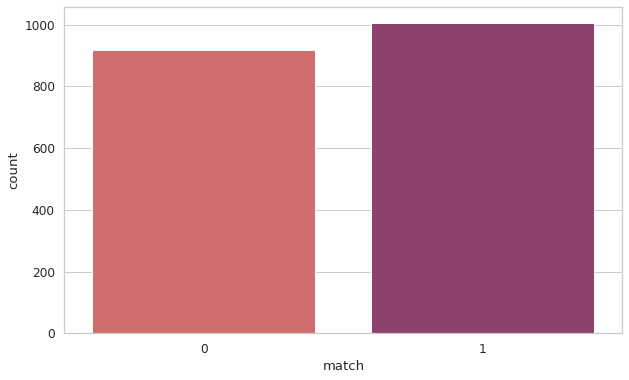

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax = sns.countplot(x="match", data=corr_under_50, palette = "flare")

**Outcome:** 

There is a positive correlation between similarity and match between both categories but not overly strong. Shows that it is not a linear realtionship between similarity and outcome. 

The higher number in matches shows that there are a large number of incorrect precitions within the true subsets. 

## Distribution<a class="anchor" id="section_4_2"></a>

This analysis is to understand if we have similarity within target classes. We use the cosine similarity to plot the distribution.

In [ ]:
# Merge the two datasets from above of >50K and <=50K

full_corr = pd.concat([corr_over_50, corr_under_50])

##### Distribution for >50K

Text(0.5, 1.0, 'Similarity Distribution >50K')

<Figure size 576x360 with 0 Axes>

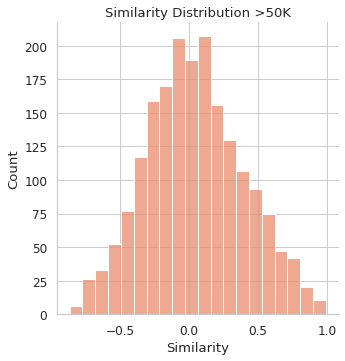

In [ ]:
plt.figure()
sns.set(style='whitegrid', palette="flare", font_scale=1.1, rc={"figure.figsize": [8, 5]})
g = sns.displot(
    corr_over_50['similarity'], kde=False, bins=20
).set(xlabel='Similarity', ylabel='Count')
plt.title('Similarity Distribution >50K')

##### Distribution for <=50K

Text(0.5, 1.0, 'Similarity Distribution <=50K')

<Figure size 576x360 with 0 Axes>

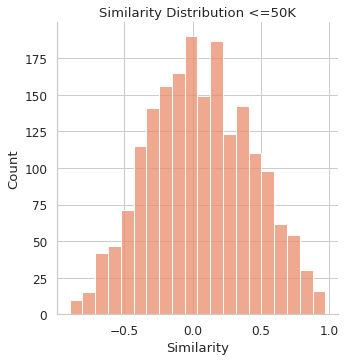

In [ ]:
plt.figure()

sns.set(style='whitegrid', palette="flare", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.displot(
    corr_under_50['similarity'], kde=False, bins=20
).set(xlabel='Similarity', ylabel='Count');
plt.title('Similarity Distribution <=50K')

##### Plot both curves on the same graph 


Text(0.5, 1.0, 'Combined Similarity Distribution')

<Figure size 576x360 with 0 Axes>

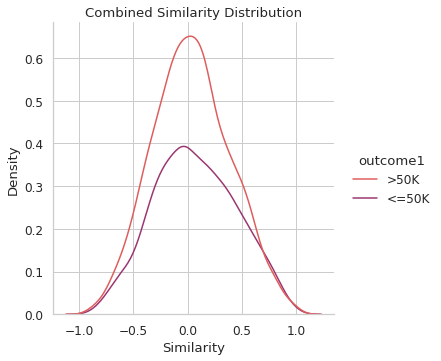

In [ ]:
plt.figure()

g = sns.displot(data=full_corr, x="similarity", hue="outcome1", kind="kde", palette="flare")
g.set_axis_labels("Similarity")
plt.title("Combined Similarity Distribution")

Plot makes sense as it shows that there are a large number of samples that are close in cosine distance but less so in terms of similarity - a similarity around 0 means that the vectors are perdendicular in the space and that the model still makes a large number of incorrect predictions for the category. 

The few values from the 0.3 and -0.3 similarity level onwards can be said to be that of strong predications with higher similarity as they are closer in the distance space.  

There is a lower peak for the <=50K category showing that it is less likely to have values assigned incorrect outcomes which is also seen in the models stronger ability to predict this category. 

In aiming for individual fairness without 'strong' features such as protected features the model finds it difficult to get every individuals outcome correct. 

## Analysis of Similarity on Incorrect predictions<a class="anchor" id="section_4_3"></a>


This section tests the areas in which the model made incorrect predictions and checking the similarity of the incorrect predictions. 


In [ ]:
test_incorrect = new_test.copy()
test_incorrect["Y_Pred"] = new_Y_pred
test_incorrect = test_incorrect.drop(['marital-status', 'relationship', 'race', 'sex', 'native-country'], True)

for i, row in test_incorrect.iterrows():
    if row.earnings == row.Y_Pred:
        test_incorrect.loc[i,'match'] = 1

    else:
        test_incorrect.loc[i,'match'] = 0


In [ ]:
test_greater_50 = test_incorrect[np.logical_and(test_incorrect['earnings'] == ">50K", test_incorrect["match"]==0.0)]
test_less_50 = test_incorrect[np.logical_and(test_incorrect['earnings'] == "<=50K", test_incorrect["match"]==0.0)]

train_greater_50 = new_train.loc[new_train['earnings'] == ">50K"]
train_less_50 = new_train.loc[new_train['earnings'] == "<=50K"]

##### Scatter for <=50K

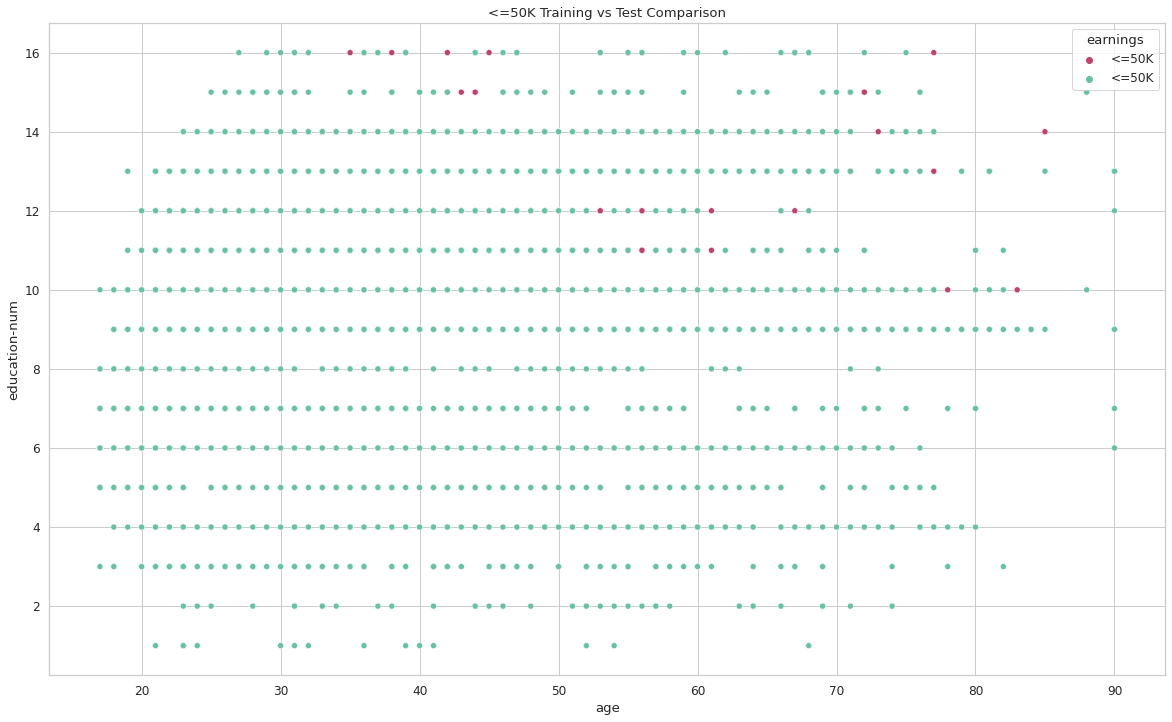

In [ ]:
plt.figure(figsize=(20,12))

sns.scatterplot(x="age", y="education-num", data=test_less_50, palette="flare", hue="earnings")
sns.scatterplot(x="age", y="education-num", data=train_less_50, palette="Set2", hue="earnings")

plt.title('<=50K Training vs Test Comparison')

plt.show()

##### Scatter for >50K

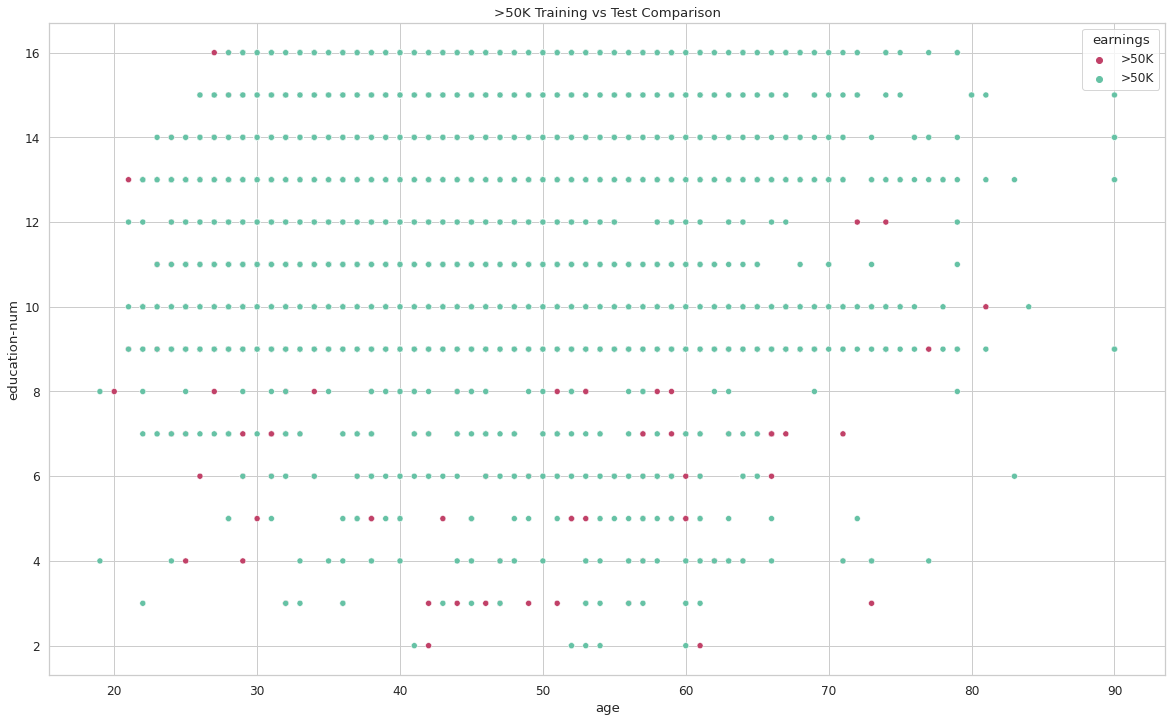

In [ ]:
plt.figure(figsize=(20,12))

sns.scatterplot(x="age", y="education-num", data=test_greater_50, palette="flare", hue="earnings")
sns.scatterplot(x="age", y="education-num", data=train_greater_50, palette="Set2", hue="earnings")


plt.title('>50K Training vs Test Comparison')

plt.show()

**Outcome:** 

Here the two highest weighted features are plotted and compared between the training and testing samples. When using age as a key factor for model decisions it is clear that not having an example of the exact age within the training dataset is causing incorrect predictions. 

Incorrect predictions on the test set are represented by the purple dots. It can be seen that with no example in the training set these are predicted incorrectly. 